
# Table of Contents
1. [Explain the data.](#explain-the-data)
2. [Converting data](#converting-data)
3. [Data cleaning](#data-cleaning)
4. [Data Goal and Definitions](#data-task)
    - [Principal Component Analysis (PCA) Pseudocode](#pca-pseudocode)
    - [Isolation Forest Pseudocode](#isolation-forest-pseudocode)
    - [Prophet Pseudocode](#prophet-pseudocode)
    - [LSTM-AutoEncoders Pseudocode](#lstm-pseudocode)
5. [PCA and Isolation Forest](#pca-forest) 
6. [Prophet](#prediction-model) 
8. [LSTM-AutoEncoders](#lstm-autoencoders)
9. [Summary](#summary)
11. [References](#references)



## <a id='explain-the-data'></a>Explain the data.
In this notebook, we will use ML to uncover corruption within the Mongolian government!

A few months ago, there was a significant protest by citizens in the streets of Ulaanbaatar, the capital of Mongolia, highlighting corruption among high-ranking government officials. The primary concern was that these officials were excessively spending government funds on themselves and their families, contributing to the country's economic decline, given Mongolia's limited financial resources. A prevalent issue is that corrupt politicians claim to initiate city projects using government budgets, but then spend excessively on tasks that could be accomplished more affordably, secretly diverting most of the funds for personal use. Another issue is their consistent denial of any wrongdoing (When? How much money? Under what category? Who? How many people?), despite clear evidence of significant embezzlement.

Therefore, I accessed the official government statistics public website and downloaded data on the Mongolian United Budget Expenditures. This dataset includes monthly Budget Expenditures over 23 years (from January 2000 to October 2023). It features columns representing dates (January 2000, February 2000, March 2000, etc.), and the rows are structured as follows:
<pre>
Total Expenditure and Net Loan Amount</br>
    1. Operating Costs </br>
        a. Goods and Services Expenses</br>
            i. Salaries and Additional Benefits</br>
            ii. Other Goods and Services Expenses</br>
        b. Interest</br>
        c. Transfers and Allocations</br>
    2. Capital Expenditure</br>
        a. From Domestic Sources</br>
        b. From Foreign Sources</br>
    3. NET LOAN</br>
    </pre>

The structure of the rows are collected in a way that the lower levels are sprecific labels of what they spend on and add up to the higher level (for example, sum of entries of 2.a and 2.b is equal to 2).
Each entry is numerical and the unit of measurement is million tugriks. 

## <a id='converting-data'></a>Converting data

In [1]:
#!pip install pandas
#!pip install scikit-learn
#!pip install numpy cython
#!pip install prophet
#!pip install tensorflow
#!pip install keras-tuner

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/tergel.s/Downloads/Minerva/budget.csv')

In [3]:
df.info()
#The dataset has no empty entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Columns: 287 entries, Categories to 2023-10
dtypes: object(287)
memory usage: 24.8+ KB


## <a id='data-cleaning'></a>Data cleaning
Since the dataset contains repetitive information, with some rows being cumulative, it's essential to retain only the unique rows to avoid redundancy. As we plan to make predictions on the variables, we aim to preserve detailed information without including too much. Consequently, we will retain rows 1.a, 1.b, and 1.c. A closer inspection of row 2.b (referenced in the code cell below) reveals very few non-zero values, and exclusively zeros since 2017. This might indicate a cessation in data collection on expenditures from foreign sources. Therefore, we will include row 2 in the dataset but exclude 2.a and 2.b. Additionally, I will include row 3 as it uniquely contains loan information.
As a result, I will only include columns: 
'Goods and Services Expenses', 
    'Interest', 
    'Transfers and Allocations', 
    'Capital Expenditure', 
    'NET LOAN'

We should also transpose the data since have the categories in the rows.

In [4]:
#Closer look at the row on expenditures from foreign sources
df.loc[9,:]

Categories    From Foreign Sources
2000-01                       0.00
2000-02                       0.00
2000-03                      62.10
2000-04                   1,373.00
                      ...         
2023-06                       0.00
2023-07                       0.00
2023-08                       0.00
2023-09                       0.00
2023-10                       0.00
Name: 9, Length: 287, dtype: object

In [5]:
""" This code cell is to filter the DataFrame to keep only the specified rows, raname columns for easier use, 
clean the structure of the entries"""

rows_to_keep = [
    'Goods and Services Expenses', 
    'Interest', 
    'Transfers and Allocations', 
    'Capital Expenditure', 
    'NET LOAN'
]
df_filtered = df[df['Categories'].isin(rows_to_keep)]

#Renaming for more convenient naming
rename_dict = {
    'Goods and Services Expenses': 'Goods_Services',
    'Interest': 'Interest',
    'Transfers and Allocations': 'Transfers_Allocations',
    'Capital Expenditure': 'Capital_Expenditure',
    'NET LOAN': 'Net_Loan'
}
# Use the .loc method to avoid SettingWithCopyWarning
df_filtered.loc[:, 'Categories'] = df_filtered['Categories'].map(rename_dict)

# Resetting index
df_filtered.reset_index(drop=True, inplace=True)

# Transpose, so the columns are the expense categories, and the rows are time points
df_transposed = df_filtered.set_index('Categories').transpose()

# Convert all columns to strings to ensure consistent processing
#df_transposed = df_transposed.applymap(str)
df_transposed = df_transposed.astype(str)

# Remove commas and convert to float
#df_transposed = df_transposed.applymap(lambda x: float(x.replace(',', '')))
df_transposed = df_transposed.apply(lambda x: x.map(lambda y: float(y.replace(',', ''))))

#copying the dataframe for the prediction model in case we change something in the dataframe for the first model
df_prediction = df_transposed

#see the changes
df_transposed.head()

Categories,Goods_Services,Interest,Transfers_Allocations,Capital_Expenditure,Net_Loan
2000-01,12224.6,280.5,7892.6,827.3,173.7
2000-02,11891.1,930.5,5068.6,840.5,4527.1
2000-03,20779.5,1409.1,8199.4,1542.7,8729.1
2000-04,13438.5,3097.3,310.2,3222.8,-173.0
2000-05,15530.6,1680.2,12436.2,2273.8,3423.4


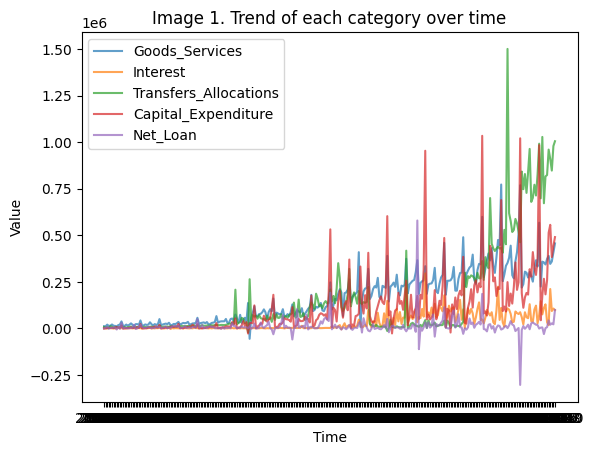

In [6]:
"""
This cell is for visualizing the intial data we have
"""
import matplotlib.pyplot as plt

# Plot each category
for category in df_transposed.columns:
    plt.plot(df_transposed.index, df_transposed[category], label=category, alpha=0.7)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Image 1. Trend of each category over time')
plt.show()

In the above graph, we see that all categories increase over time, some significantly and some slowly. We can see that transfers_allocations increase the most over time. Capital expenditure seems to have significant bummps over time. Goods_services also increase significantly. As a first guess, we could suspect that they tend to use these categories to steal large amount of money.

Let's now look at whether there any correlations between the expense categories below.

## <a id='data-task'></a>Goal and Definitions


The primary goal is to find any clues indicating when the money might have been stolen, and whether this has been an ongoing issue. However, since nothing is clear to the public yet, we do not have clearly labeled data to verify the accuracy of our models. First we will use PCA to see which columns to have the most variance. Principal Component Analysis (PCA) which is a technique used to emphasize variation and bring out strong patterns in a dataset. Then, we will investigate this dataset using an anomaly detection model to identify trends, and employ a prediction model to compare whether the actual data aligns with the model’s predictions. This approach serves as another method of anomaly detection. We will then combine findings from these different models to discern any patterns in the timing and amount of money potentially stolen.

Selecting a Test Set for the Prediction Model:

One option is to extract the last few years as a test set. However, the past five years have seen numerous changes, such as COVID, significant fluctuations in tugrik rates, and changes in international opportunities. Therefore, using the past five years as a test case may not be advisable, as they are likely outliers with considerable variance in expenses. Instead, we will use rolling cross-validation for the time-series data we have. This process is visualized below. It is a suitable option because it is impractical to have the test set precede the training set, and as training progresses, we will accumulate more data for the training set.
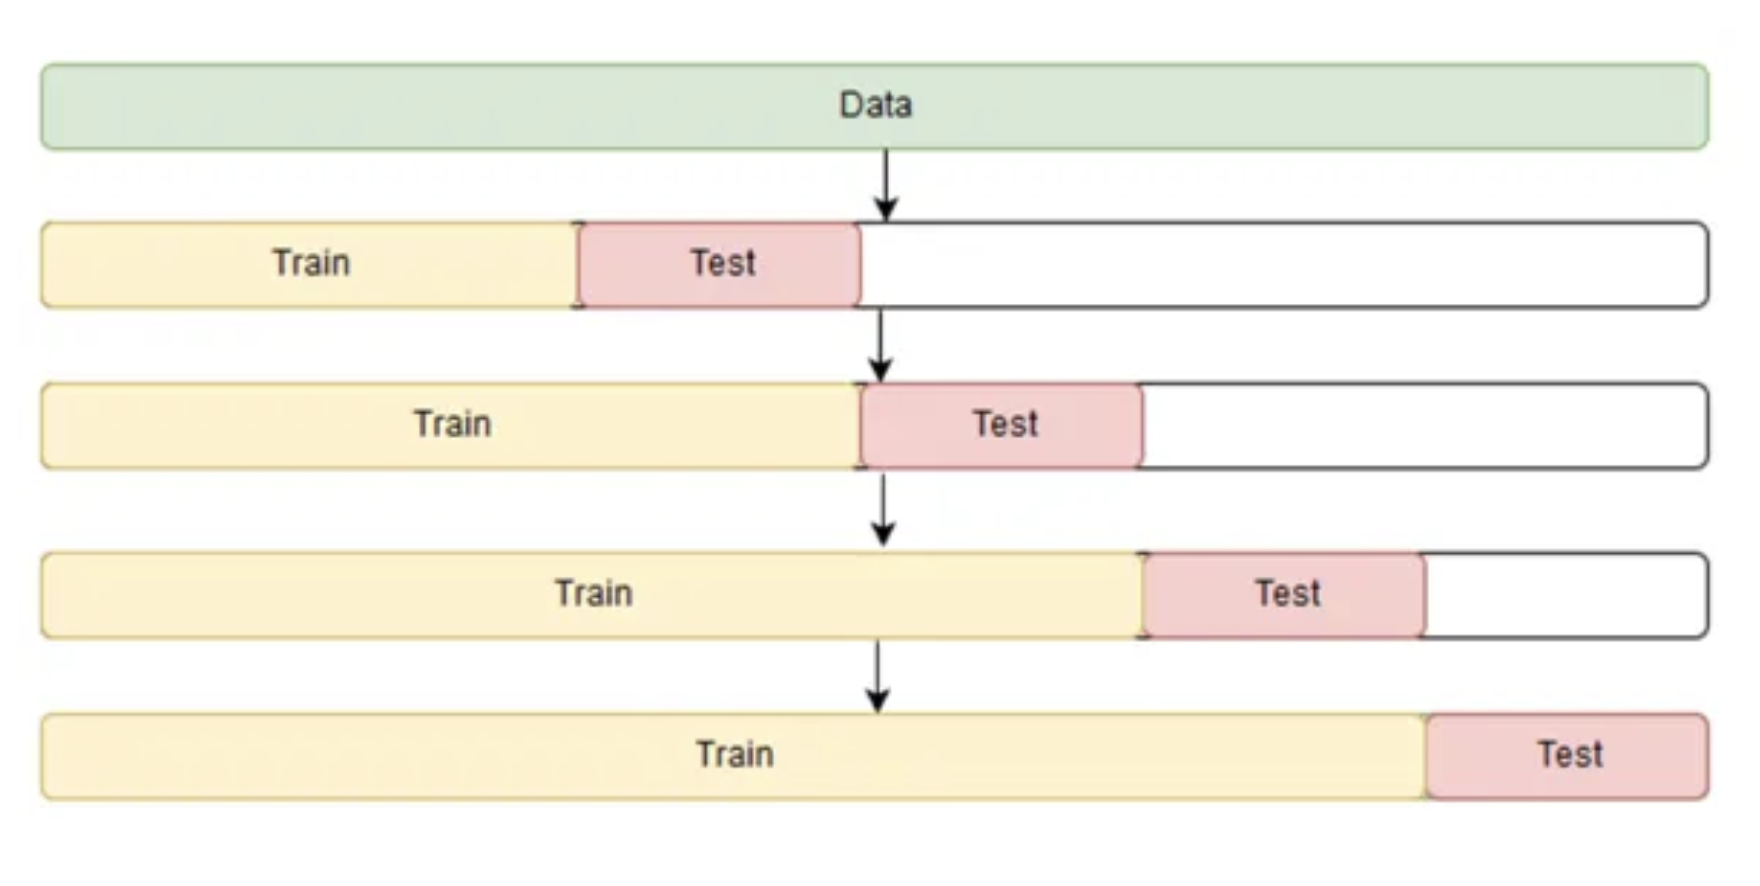

### <a id='pca-pseudocode'></a>Principal Component Analysis (PCA) Pseudocode

Input
- `X`: a D-dimensional dataset of N samples (N x D matrix)
- `k`: the number of principal components to retain (`k ≤ D`)

Output
- `Y`: the reduced dataset (N x k matrix)
- `V`: the top k principal components (D x k matrix)

Algorithm
1. **Standardize the dataset**:
   - For each dimension `d` in `D`:
     - Subtract the mean of dimension `d` from each element in dimension `d`.
     - (Optional) Divide each element in dimension `d` by the standard deviation of `d`.

2. **Compute the covariance matrix `C`**:
   - `C = (1/N) * X^T * X` (where `X^T` is the transpose of `X`).

3. **Perform eigenvalue decomposition on `C`**:
   - Compute eigenvalues and eigenvectors of `C`.
   - Let `λ` be the vector of eigenvalues.
   - Let `V` be the matrix of eigenvectors.

4. **Sort the eigenvectors by decreasing eigenvalues**:
   - Sort the columns of `V` in decreasing order of corresponding eigenvalues in `λ`.

5. **Select the top `k` eigenvectors**:
   - `V_k =` the first `k` columns of `V`.

6. **Project the data onto the new subspace**:
   - `Y = X * V_k`
     
Return

- Return `Y` and `V_k`.


###  <a id='isolation-forest-pseudocode'></a>Pseudocode for Isolation Forest Algorithm with Explanations

**Function IsolationForest(D, t, s)**
- **Description**: Builds an Isolation Forest, an ensemble of Isolation Trees.
- **Input**: Dataset `D`, number of trees `t`, sample size `s`.
- **Process**:
  1. Initialize an empty set of trees, `Forest`.
  2. For `i` from 1 to `t`:
     - Take a random sample `Sample` from `D` of size `s`.
     - Build an isolation tree `Tree` from `Sample`.
     - Add `Tree` to `Forest`.
  3. Return `Forest`.
- **Significance**: This function creates the forest by generating multiple isolation trees, each constructed from a random subset of the data. The isolation trees individually contribute to identifying anomalies by isolating points.

**Function iTree(Sample, currentDepth)**
- **Description**: Recursively builds an isolation tree.
- **Input**: A sample `Sample`, current depth `currentDepth`.
- **Process**:
  1. If `Sample` length is <= 1 or `currentDepth` >= limit, return a leaf node with size(`Sample`).
  2. Randomly select a feature `q` and a split value `p`.
  3. Split `Sample` into left and right subsets based on `q` and `p`.
  4. Return a node with feature `q`, split value `p`, left tree `iTree(Left, currentDepth+1)`, and right tree `iTree(Right, currentDepth+1)`.
- **Significance**: The isolation tree isolates each point by recursively splitting the data. The path a point takes in the tree (short for anomalies and long for normal points) forms the basis for anomaly detection.

**Function PathLength(x, Tree, currentDepth)**
- **Description**: Computes the path length of a data point in a tree.
- **Input**: Data point `x`, a tree `Tree`, current depth `currentDepth`.
- **Process**:
  1. If `Tree` is a leaf, return `currentDepth + c(size(Tree))`.
  2. Determine the split feature `q` and value `p` of `Tree`.
  3. If `x[q] < p`, recurse left, otherwise recurse right.
  4. Return the computed path length.
- **Significance**: This function calculates how deep into the tree a data point goes, which is a key indicator of its normality or anomaly. Shorter paths suggest anomalies.

**Function AnomalyScore(x, Forest)**
- **Description**: Computes the anomaly score of a data point.
- **Input**: Data point `x`, an Isolation Forest `Forest`.
- **Process**:
  1. Calculate the average path length `h` for `x` over all trees in `Forest`.
  2. Return the anomaly score as `2^(-h / c(s))`.
- **Significance**: This function aggregates the path lengths from all trees to calculate a standardized anomaly score. A higher score indicates a higher likelihood of the point being an anomaly.

** Mathematical Notation **

- **Path Length \( h(x) \)**: The number of edges a data point `x` traverses in a tree from the root to the leaf.
- **Anomaly Score \( s(x, n) \)**: The anomaly score for a data point `x` in a dataset of size `n` is calculated as: `s(x, n) = 2^(-E(h(x))/c(n))`
  where ` E(h(x))` is the average path length over all trees in the forest, and `c(n)` is the average path length in an unsupervised binary search tree:
  `c(n) = 2H(n-1) - (2(n-1)/n)`
  `H(i)` is the harmonic number, approximated by `ln(i) + 0.5772156649`(Euler's constant).


Then, we will use a prediction model Prophet developed by Facebook. It is a predictive model specifically for time series data that handles outliers, missing values, and seasonality. It uses a combination of a regression model and Bayesian inference and can generate probabilistic forecasts that provide a measure of uncertainty around the point forecast.

In this problem, we could consider using an LSTM for its ability to capture complex patterns and dependencies in time series data over long sequences due to its recurrent nature and memory cells. However, Prophet is a better fit for it because it is specifically designed for time series forecasting with intuitive and easily interpretable models that automatically handle seasonality and trends without the need for extensive hyperparameter tuning. Prophet also excels in incorporating the effects of holidays and other special events, which can be particularly challenging for LSTMs without feature engineering. 

### <a id='prophet-pseudocode'></a>Facebook Prophet Time Series Forecasting Pseudocode

**Input:**
- **Y**: Historical Time Series Data
- **ds**: Time Stamps corresponding to Y
- **Configurable Parameters**: Growth, Seasonalities, Holidays, Changepoints

**Procedure:**
1. **Initialize Model:**
   - **Choose growth model:** Linear or Logistic
   - **Set up seasonal components:** Fourier series for weekly, yearly, daily seasonality
   - **Define holiday and special event effects**
   - **Specify changepoints for trend adjustments**

2. **Define Trend Component g(t):**
   - IF growth == 'linear' THEN 
     - `g(t) = k * t + m`
   - ELSE IF growth == 'logistic' THEN
     - `g(t) = C / (1 + exp(-(k * (t - m))))`
   - Incorporate changepoints to adjust trend flexibly

3. **Define Seasonality Component s(t):**
   - FOR each seasonality (weekly, yearly, daily) DO
     - `s(t) += ∑[n=1 to N](a_n * cos(2πnt/P) + b_n * sin(2πnt/P))`
     - // N: Fourier order, P: period, a_n, b_n: coefficients
   - ENDFOR

4. **Define Holiday Component h(t):**
   - Model each holiday effect as a separate regressor with a prior scale

5. **Define Error Term ε(t):**
   - Assume `ε(t) ~ N(0, σ^2)`

6. **Combine Components:**
   - `y(t) = g(t) + s(t) + h(t) + ε(t)`

7. **Estimate Parameters:**
   - Apply Bayesian inference using MCMC or Variational Inference to estimate parameters
   - Parameters include k, m, C (for logistic growth), a_n, b_n, holiday effects, etc.

8. **Forecasting:**
   - Extend `g(t)`, `s(t)`, `h(t)` to future dates `ds_future`
   - Compute `Y_hat` for each future date using estimated model

9. **Output:**
   - **Y_hat:** Forecasted values
   - **Components:** Decomposition of forecast into trend, seasonality, holidays
   - **Uncertainty Intervals:** Confidence intervals for the forecast

10. **Model Tuning and Diagnostics:**
    - Apply time series cross-validation for performance evaluation
    - Adjust hyperparameters based on model diagnostics

**End Procedure**


### <a id='lstm-pseudocode'></a>LSTM-AutoEncoders Pseudocode
LSTM-AutoEncoders are a specialized form of neural networks designed for sequence processing, combining the concepts of LSTMs and autoencoders. LSTM, extension of RNN, can memorize important information from a sequence of data. "LSTM consists of feedback connections which mean the entire sequence data, as well as a single data point, could be processed by the network" (Pooyan Mobtahej et al.).
AutoEncoder consists of encoder and decoder. In encoder, the the underlying features of the data is represented in a reduced dimension. The decoder would take that and recreate the original data. It is powerful because it can handle large data and make feature selection. 
LSTM consists of:
- input gate: decides which information will be transferred to the cell.
    - (see below formula for Input gate)
- output gate: updates the previous time step in the hidden layer and the output of the given data.
    - (see below formula for Output gate and New hidden state)
- forget gate: decides which information is kept from the previous state
    - (see below formula for Forget gate)
In every cell, the update gate updates each cell's information
    - (see below formula for Candidate memory cell and New memory cell)
1. Encoder LSTM:
- **Input**: Sequence $$ X = \{x_1, x_2, ..., x_T\},$$ where x_t is the input at time step t.

- Each LSTM unit at time t computes the following:
  - **Forget gate**: $$ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $$
  - **Input gate**: $$ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $$
  - **Output gate**: $$ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) $$
  - **Candidate memory cell**: $$ \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) $$
  - **New memory cell**: $$ C_t = f_t \times C_{t-1} + i_t \times \tilde{C}_t $$
  - **New hidden state**: $$ h_t = o_t \times \tanh(C_t) $$
- **Output**: Encoded state  h_T or C_T (final hidden state or memory cell state)
2. Decoder LSTM:
- **Input**: Encoded state from the encoder LSTM.
- **Similar LSTM unit computations as the encoder** but for decoding, often starting with the encoded state and generating the output sequence $$ Y = \{y_1, y_2, ..., y_T\} $$.
- **Target of the decoder**: Typically to reconstruct the original input sequence X.

#### Mathematical Formulas
- σ: Sigmoid activation function.
- tanh:Hyperbolic tangent activation function.
- W and b: Weight matrices and bias vectors for different gates (subscripted with f,i,o,C for forget, input, output gates, and candidate memory cell, respectively).
- Concatenation of previous hidden state and current input: $$ [h_{t-1}, x_t]  $$ 
- 
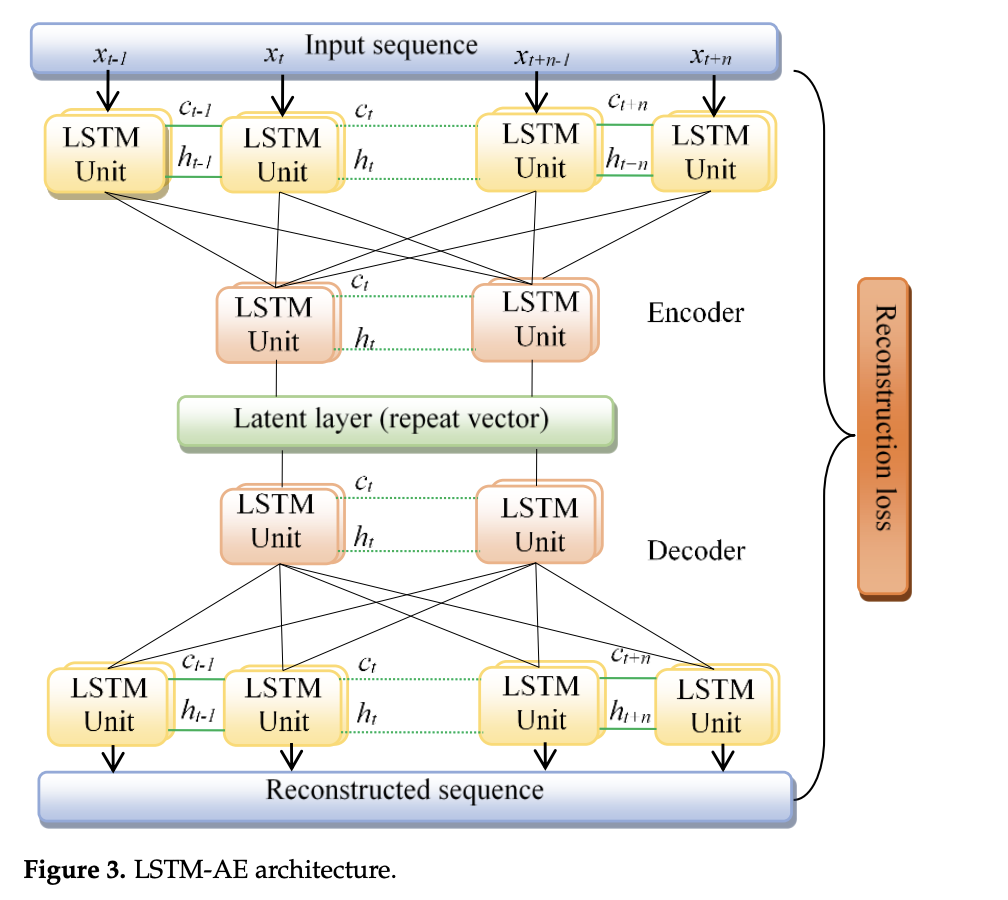
Graph 1.(Qais et al.)

## <a id='pca-forest'></a>PCA and Isolation Forest

Before we start working on the anomaly detection and prediction models, let's try to understand which columns have the most variance. 

In [7]:
"""
This code performs PCA to compute each column's variances of the original variables in the dataset 
and returns the cumulative explained variance
"""

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the data
df_scaled = scaler.fit_transform(df_transposed)

# Initialize PCA
pca = PCA(n_components=len(df_transposed.columns))

# Fit PCA on the standardized data
pca.fit(df_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Match the explained variance ratio with the original column names
pca_importance = dict(zip(df_transposed.columns, explained_variance_ratio))

# Sort the variables based on their importance scores
sorted_importance = sorted(pca_importance.items(), key=lambda x: x[1], reverse=True)

# Print the sorted importance scores
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

# You might want to look at the cumulative explained variance to decide how many components to consider
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Print the cumulative explained variance
for idx, cumulative_variance in enumerate(cumulative_explained_variance):
    print(f"Principal Component {idx+1}: {cumulative_variance:.4f}")

Goods_Services: 0.5721
Interest: 0.2002
Transfers_Allocations: 0.1163
Capital_Expenditure: 0.0760
Net_Loan: 0.0354
Principal Component 1: 0.5721
Principal Component 2: 0.7723
Principal Component 3: 0.8886
Principal Component 4: 0.9646
Principal Component 5: 1.0000


From the results of the PCA, we can see that the Goods_Services column constitutes more than 50% of the variance. The Interest column adds another 20% of variance, and Transfers_Allocations adds another 10%, which all together account for 88% of the variance in the data. This number is high enough for us to understand the general patterns in the whole dataset.

We could ideally take these columns to execute the models, but we want to look at the anomalies and predictions so we could obscure the individual contributions of each category to the forecast. Therefore, we will still use all five columns in the next steps, but understanding these contributions of each column to the variance of the whole data is useful in making conclusions with the combinations of the findings in the next sections. 

In [8]:
"""
This cell uses a IsolationForest model to output years that could be considered as anomaly across all columns
"""
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


# Standardize the data since Isolation Forest can be sensitive to the scale of the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_transposed)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model
iso_forest.fit(df_scaled)

# Predict anomalies (-1 for outliers, 1 for inliers)
anomalies = iso_forest.predict(df_scaled)

# Add the predictions to the DataFrame
anomaly_indices = anomalies == -1

# Use the boolean array to filter the DataFrame and find the anomaly points
anomaly_points = df_transposed[anomaly_indices]

# Display the anomalies
print(anomaly_points)


Categories  Goods_Services  Interest  Transfers_Allocations  \
2011-12           247527.4    2905.9               209373.2   
2013-07             8826.9   31371.4               137246.6   
2014-12           389765.7  148448.7               -13450.5   
2015-12           373984.8  216966.7               417631.5   
2016-07           366411.6   34443.1                12973.8   
2016-08           185733.1   62442.2                 9030.5   
2016-12           334383.1  296183.5                45207.2   
2017-12           459685.2  178157.2                42934.1   
2018-12           489743.6  102651.5                36319.5   
2019-12           599177.5   48569.9               361700.3   
2020-10           475233.8  224425.6               438514.4   
2020-12           772600.6  110188.3               432565.6   
2021-04           351977.8  108018.8              1500320.8   
2021-12           768611.1   87266.9               463133.2   
2022-06           305056.6  130290.1               9637

If we look at the result above, we can see that there are no anomalies identified in the first 10 years, but 2023 alone has the most anomaly detected. This could mean different things:
- that there was more malicious activity,
- or there was a high rate increase in tugriks
- or spent significantly more money in general
- and many other reasons.
However, if we think logically about it, we should observe more anomalies during the years there was a covid lockdown. However, we don't see that many anomalies during those years.
  
<div style="background-color:#e7f3fe; padding: 10px;">
One interesting aspect from the resut above is that there are many anomalies detected on December for different years. While all the other months are repeated only 1 or 2 times, or even none at all, december's expenditure is recognized 10 times as an anomaly. This could be due to the fact that government projects often face pressure to complete their work towards the end of the year. 
</div>

In [9]:
"""
This cell uses IsolationForest algorithm for each column separately and counts how many anomalies are detected in each one of them.
"""

# Initialize a dictionary to store the anomaly counts for each column
anomaly_counts = {}

# Loop over each column index in df_transposed to apply Isolation Forest
for i, column in enumerate(df_transposed.columns):
    # Isolate the column for scaling
    column_data_scaled = df_scaled[:, i].reshape(-1, 1)

    # Initialize the Isolation Forest model
    #If contamination is set to a floating-point value, it specifies the expected proportion of outliers directly. 
    #When set to 'auto', the algorithm will automatically determine the contamination factor based on the dataset. 
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42) 

    # Fit the model on the scaled data of the current column
    iso_forest.fit(column_data_scaled)

    # Predict anomalies (-1 for outliers, 1 for inliers)
    anomalies = iso_forest.predict(column_data_scaled)

    # Store the anomaly count for the current column
    anomaly_counts[column] = sum(anomalies == -1)

# Identify the column with the most anomalies
most_anomalous_column = max(anomaly_counts, key=anomaly_counts.get)

print("Count of anomalies in each category:", anomaly_counts)

Count of anomalies in each category: {'Goods_Services': 39, 'Interest': 81, 'Transfers_Allocations': 77, 'Capital_Expenditure': 41, 'Net_Loan': 25}


In the above cell, we see that the columns with the most anomalies are 'Interest': 81, 'Transfers_Allocations': 77, 'Capital_Expenditure': 41. The Interest column is interesting in this case because it generally had low expense numbers. One would not consider this column as suspicious compared to other columns. In the visuals below, we can see that the last 10 years of entries in Interest have many significant ups and downs, which is why the model classifies them as anomalies. In general, the visualization below shows that many extreme spikes in the data are recognized as anomalies.

Let's also combine these findings with the insights of PCA. In PCA, we noticed, Goods_Services had contributed to more than 50% of the  variations in all of the dataset, but we do not see so much anomalies in the column. Interest column added only 20% variance but has much more anomalies detected. Transfers_Allocations added another 10% variance, but has the second most anomalies. This is interesting because PCA suggests that these components could be the main drivers of the underlying structure in the data; however, the anomaly detection findings indicate that the columns contributing less to overall variance (Interest and Transfers_Allocations) are exhibiting more anomalous behavior. This discrepancy could imply that while Goods_Services dominates the general trend and seasonality captured by PCA, the Interest and Transfers_Allocations categories may be subject to more irregular fluctuations or external influences that lead to anomalies, which aren't necessarily captured by their variance contributions in PCA.

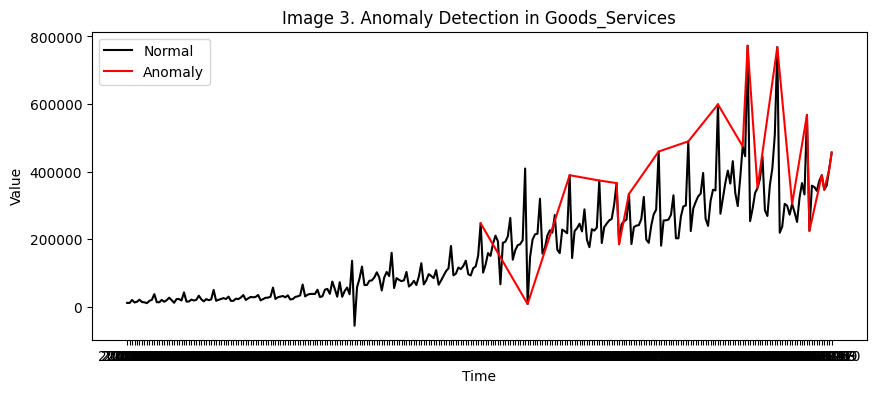

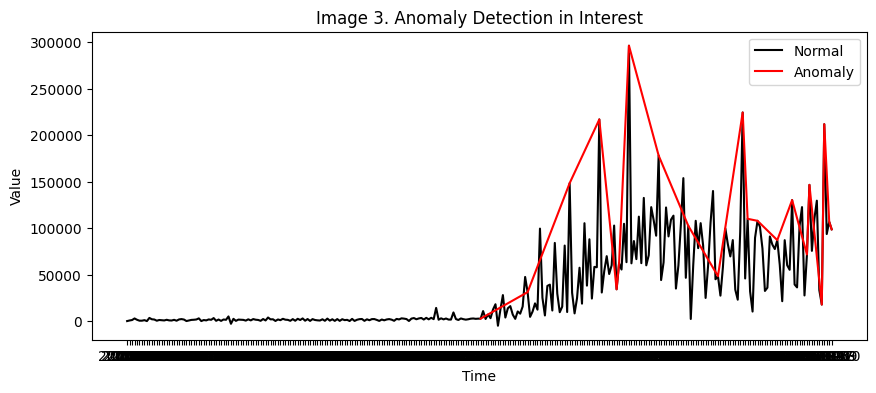

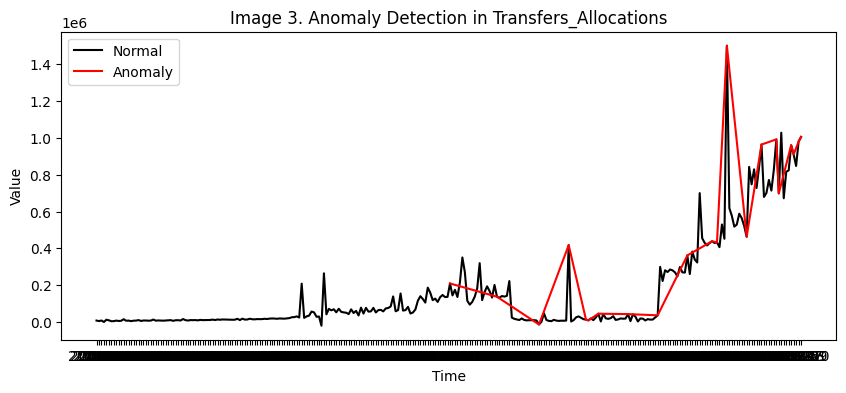

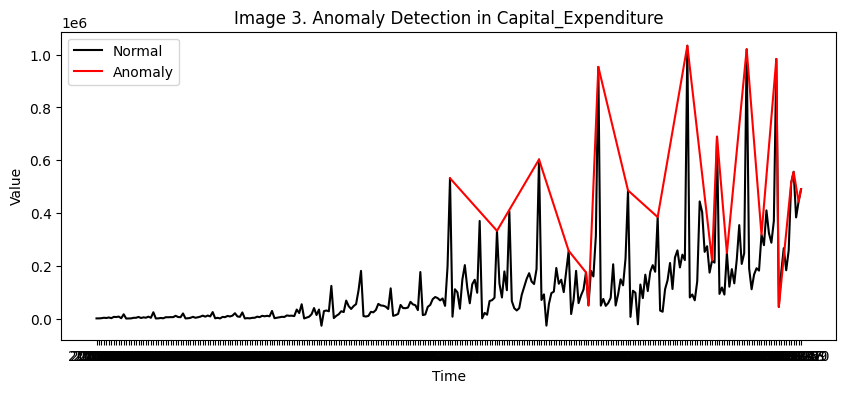

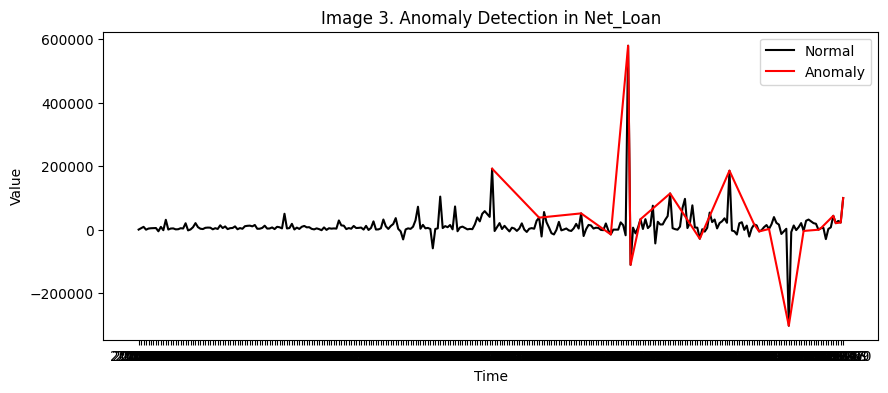

In [10]:
"""
This cell visualizes the actual data for each column vs the points recognized as anomalies.
"""

# Plotting each feature over time
for column in df_transposed.columns[:]: 
    plt.figure(figsize=(10, 4))
    plt.title(f"Image 3. Anomaly Detection in {column}")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.plot(df_transposed.index, df_transposed[column], 'k-', label='Normal')
    plt.plot(anomaly_points.index, anomaly_points[column], 'r-', label='Anomaly')
    plt.legend()
    plt.show()


## <a id='prediction-model'></a>Prophet

Now, let's develop the prediction model. Since we have 23 years' worth of data, with rolling cross-validation, we can train many models. The initial_train_size should be large enough to capture the full seasonality and trend patterns in the data; therefore, we will choose 60 months (5 years). For the roll_window, we will select 12 months (1 year), as this allows each validation period to capture the yearly seasonality.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
19:44:33 - cmdstanpy - INFO - Chain [1] start processing
19:44:33 - cmdstanpy - INFO - Chain [1] done processing
19:44:33 - cmdstanpy - INFO - Chain [1] start processing
19:44:33 - cmdstanpy - INFO - Chain [1] done processing
19:44:33 - cmdstanpy - INFO - Chain [1] start processing
19:44:33 - cmdstanpy - INFO - Chain [1] done processing
19:44:33 - cmdstanpy - INFO - Chain [1] start processing
19:44:34 - cmdstanpy - INFO - Chain [1] done processing
19:44:34 - cmdstanpy - INFO - Chain [1] start processing
19:44:34 - cmdstanpy - INFO - Chain [1] done processing
19:44:34 - cmdstanpy - INFO - Chain [1] start processing
19:44:34 - cmdstanpy - INFO - Chain

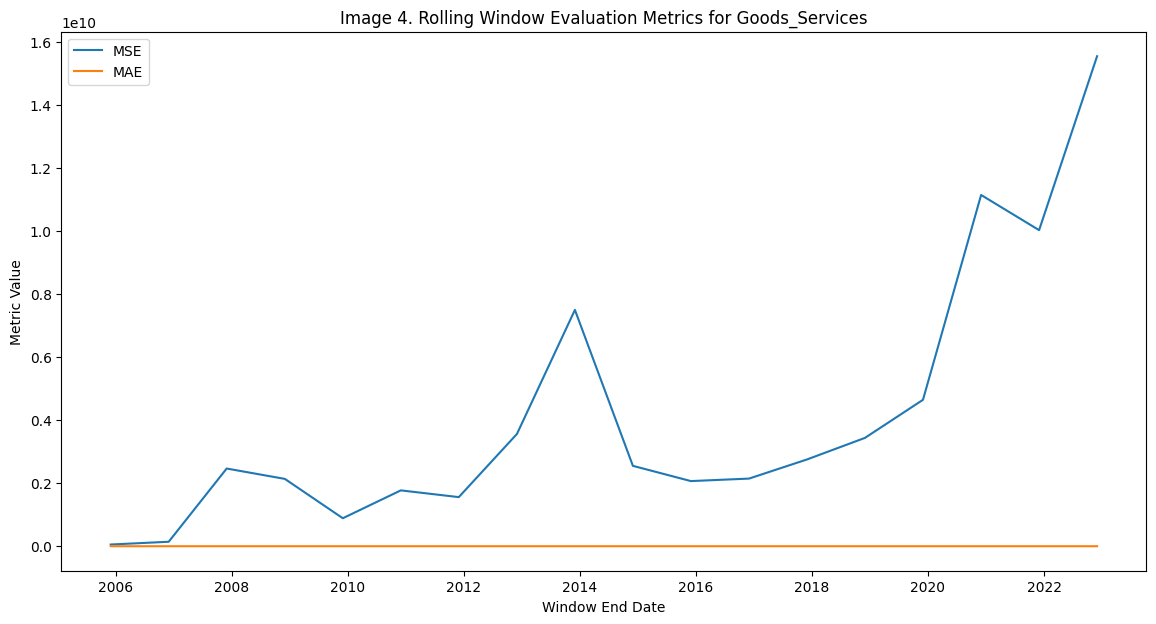

19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] done processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] done processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] done processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] done processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] done processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] done processing
19:44:36 - cmdstanpy - INFO - Chain [1] start processing
19:44:36 - cmdstanpy - INFO - Chain [1] done processing
19:44:36 - cmdstanpy - INFO - Chain [1] start processing
19:44:36 - cmdstanpy - INFO - Chain [1] done processing
19:44:36 - cmdstanpy - INFO - Chain [1] start processing
19:44:36 - cmdstanpy - INFO - Chain [1]

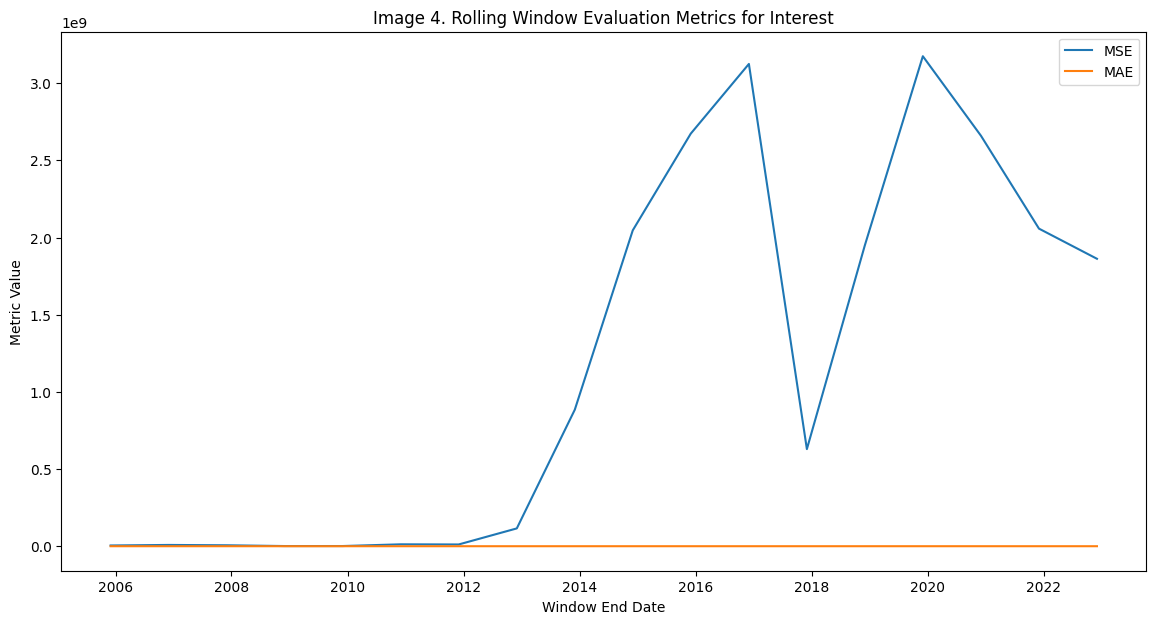

19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:38 - cmdstanpy - INFO - Chain [1] done processing
19:44:38 - cmdstanpy - INFO - Chain [1] start processing
19:44:38 - cmdstanpy - INFO - Chain [1] done processing
19:44:38 - cmdstanpy - INFO - Chain [1] start processing
19:44:38 - cmdstanpy - INFO - Chain [1]

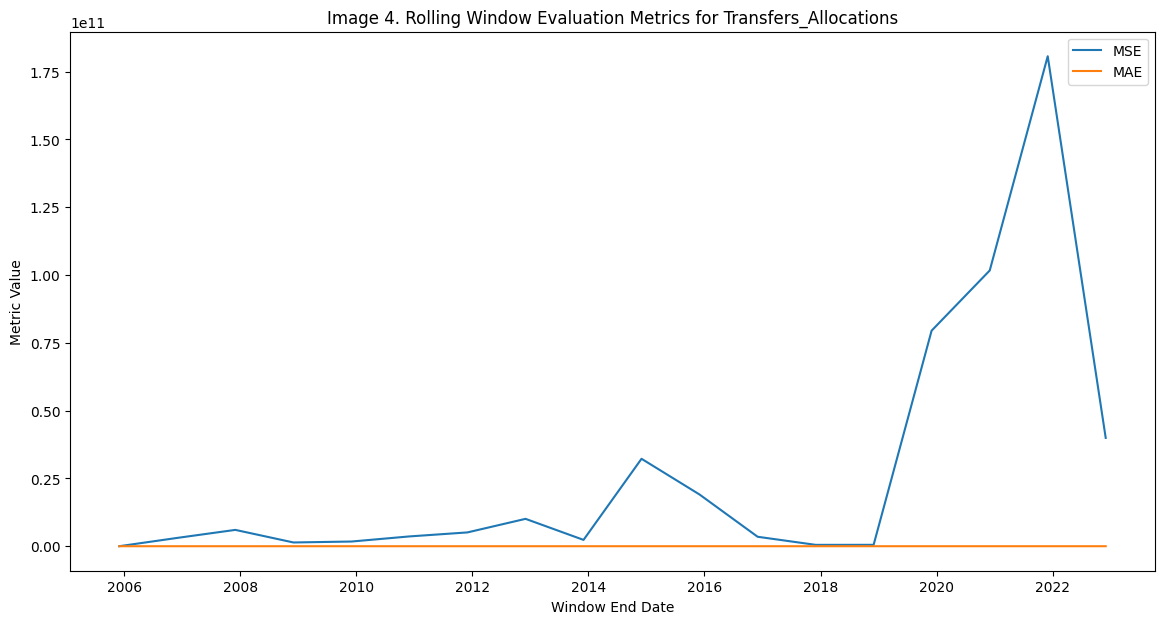

19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:39 - cmdstanpy - INFO - Chain [1] start processing
19:44:39 - cmdstanpy - INFO - Chain [1] done processing
19:44:40 - cmdstanpy - INFO - Chain [1] start processing
19:44:40 - cmdstanpy - INFO - Chain [1] done processing
19:44:40 - cmdstanpy - INFO - Chain [1] start processing
19:44:40 - cmdstanpy - INFO - Chain [1]

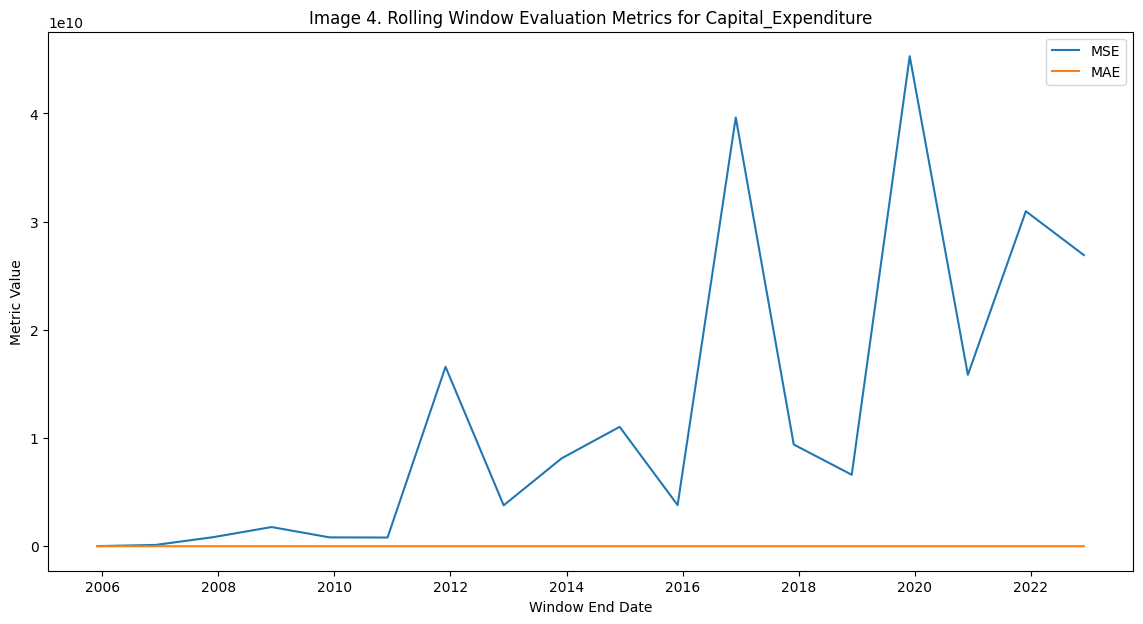

19:44:40 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1]

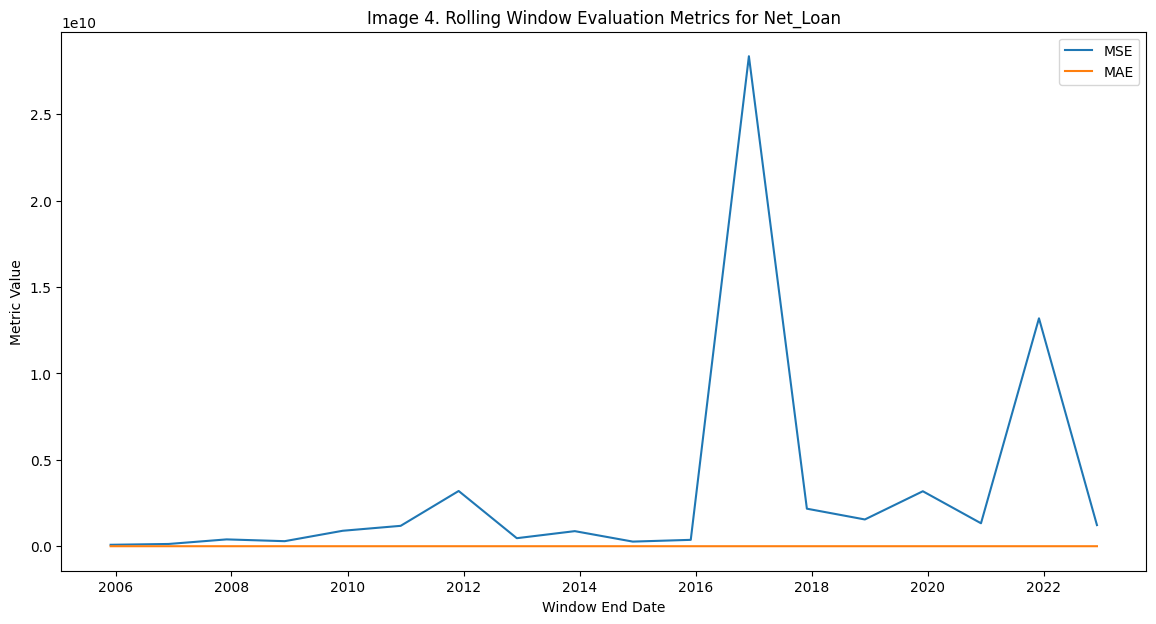

In [11]:
"""
This cell implements Prophet prediciton on each column/category in the the dataset using 
rolling cross validation (to split training and test set) and computes the evaluation metrics (MAE, MSE)
for each iteration of cross validation. 
"""
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

df_prediction.index = pd.to_datetime(df_prediction.index)

# Initialize dictionaries 
models = {}
predictions_vs_actual = {}
metrics = {}
average_metrics = {}  # Dictionary to store average metrics
aggregated_predictions = {}  # Dictionary to store aggregated predictions for each column

# Define the initial size of the training set and the rolling window size
initial_train_size = 60  # 60 months
roll_window = 12  # 12 months

# Loop through each column to create separate models for each expense category
for column in df_prediction.columns:
    prophet_df = pd.DataFrame({
        'ds': df_prediction.index,
        'y': df_prediction[column]
    })

    # Initialize lists to store metrics for each rolling window
    mse_values = []
    mae_values = []
    window_end = []
    
    # Initialize DataFrame to aggregate predictions
    aggregated_pred_df = pd.DataFrame()

    # Start rolling cross-validation
    for i in range(initial_train_size, len(prophet_df) - roll_window, roll_window):
        # Define the training and test sets
        train_df = prophet_df.iloc[:i]
        test_df = prophet_df.iloc[i:i + roll_window]

        # Create and fit the Prophet model on the training set
        # We are setting the seasonality to yearly under the assumption that most project happen in the summer
        model = Prophet(yearly_seasonality=True, daily_seasonality=False)
        model.fit(train_df)

        # Make predictions on the test set period
        future = model.make_future_dataframe(periods=roll_window, freq='M')
        forecast = model.predict(future)

        # Extract the predicted values for the test set period
        y_pred = forecast['yhat'].iloc[-roll_window:]

        # Store the predicted and actual values together
        comparison_df = test_df.copy()
        comparison_df['predicted'] = y_pred.values

        # Aggregate the predictions
        aggregated_pred_df = pd.concat([aggregated_pred_df, comparison_df])

        # Calculate and store the evaluation metrics
        mse = mean_squared_error(comparison_df['y'], comparison_df['predicted'])
        mae = mean_absolute_error(comparison_df['y'], comparison_df['predicted'])
        mse_values.append(mse)
        mae_values.append(mae)
        window_end.append(prophet_df.index[i + roll_window - 1])  # Record the window end time

    # Store aggregated predictions for the column
    aggregated_predictions[column] = aggregated_pred_df

    # Store metrics in the dictionary
    metrics[column] = {'mse': mse_values, 'mae': mae_values, 'window_end': window_end}

    # Calculate and store the average metrics
    average_metrics[column] = {
        'average_mse': sum(mse_values) / len(mse_values),
        'average_mae': sum(mae_values) / len(mae_values)
    }
    
    # Plot the evaluation metrics over time
    plt.figure(figsize=(14, 7))
    plt.plot(window_end, mse_values, label='MSE')
    plt.plot(window_end, mae_values, label='MAE')
    plt.title(f"Image 4. Rolling Window Evaluation Metrics for {column}")
    plt.xlabel('Window End Date')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()



In [12]:
"""
If the visualizations are hard to grasp:
this cell computes the average of each metric for all the iterations for each column.
"""
for column, avg_metrics in average_metrics.items():
    print(f"Average Metrics for {column}: MSE = {avg_metrics['average_mse']}, MAE = {avg_metrics['average_mae']}")


Average Metrics for Goods_Services: MSE = 4129817179.718995, MAE = 42591.173289345774
Average Metrics for Interest: MSE = 1179017952.4920409, MAE = 19184.54957115375
Average Metrics for Transfers_Allocations: MSE = 27277077683.026543, MAE = 101436.75344812953
Average Metrics for Capital_Expenditure: MSE = 12351882019.98877, MAE = 59419.00818493636
Average Metrics for Net_Loan: MSE = 3285786334.3098135, MAE = 26172.140025328918


The metrics for evaluation that we used are Mean squared error (MSE), Mean absolute error(MAE)) and have the following formulas:
MAE = (1/n) Σ(i=1 to n) |y_i – ŷ_i|
MSE = (1/n) Σ(i=1 to n) (y_i – ŷ_i)^2
where
n	=	number of data points
y_i	=	observed values
ŷ_i	=	predicted values

The above graphs show that the more we train with more data, the worse the predictions are compared to the real data. The average in evaluation metrics of all predictions shows that the columns Transfers_Allocations, Capital_Expenditure, and Goods_Services have the worst performance in prediction. Even though the evaluation metrics seem to indicate that the model performs poorly, it could also be used as a clue. With the assumption that the model predicts well and the true cost of all the projects done in the city is visualized by the prediction line, MAE could be an interesting approach to predicting how much money the politicians stole. However, we cannot be sure, but it is an interesting way to look at it.

Below, we can visualize the aggregated actual vs. predicted values for each column. The overall trend of the graphs seems to match the actual data, but the actual data has many more spikes. For example, in the Goods_Services and Capital_Expenditure columns, the prediction accurately predicts the linear trend but fails to account for the "high" highs and low "lows". In the Interest column, we can observe that the model accurately predicted on the test set until 2012. After 2012, the model learned to include more spikes and increases but could not predict such high variations as in the actual data. Previously, we identified 81 anomalies in the Interest column data, and now we can clearly see how the crazy spikes are something the prediction algorithm could not catch up with, even if it tried to adjust to the spikes.

Even though the graph above seems to show that the prediction got worse over time, we can see below that the model predicted general trends well in all columns. The reason we see high values in MSE and MAE is that the real data has many spikes and jumps in the past around 10-ish years. Combining the graphs above and below, the observed high jumps in the data could indicate anomalies, supporting what we have seen from the Isolation Forest anomalies model.

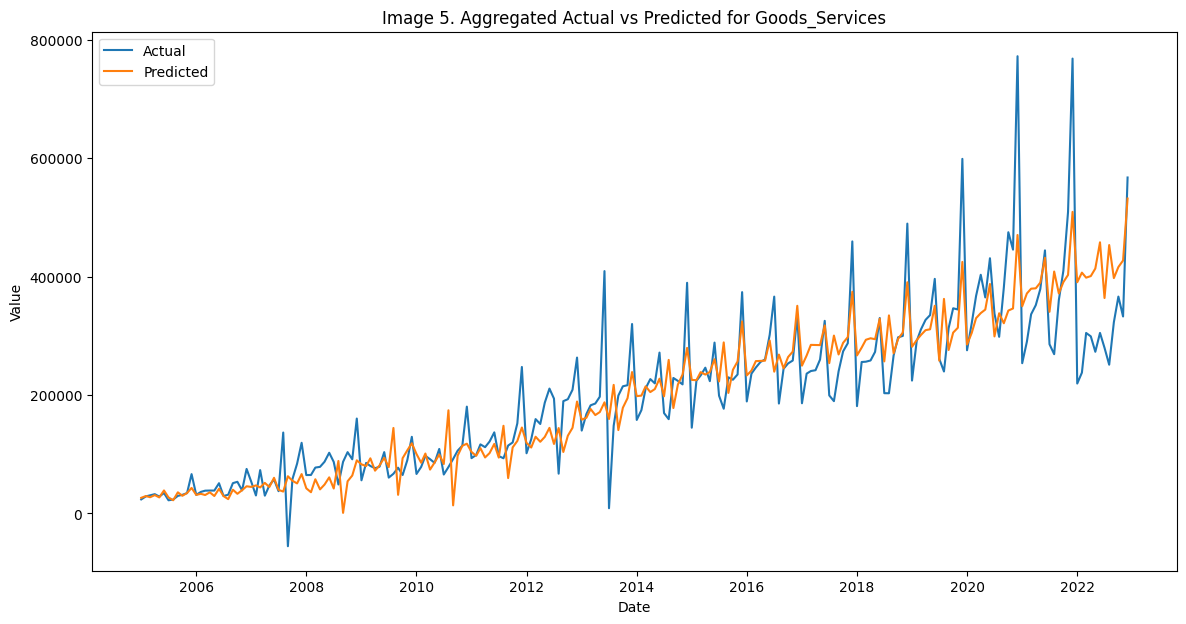

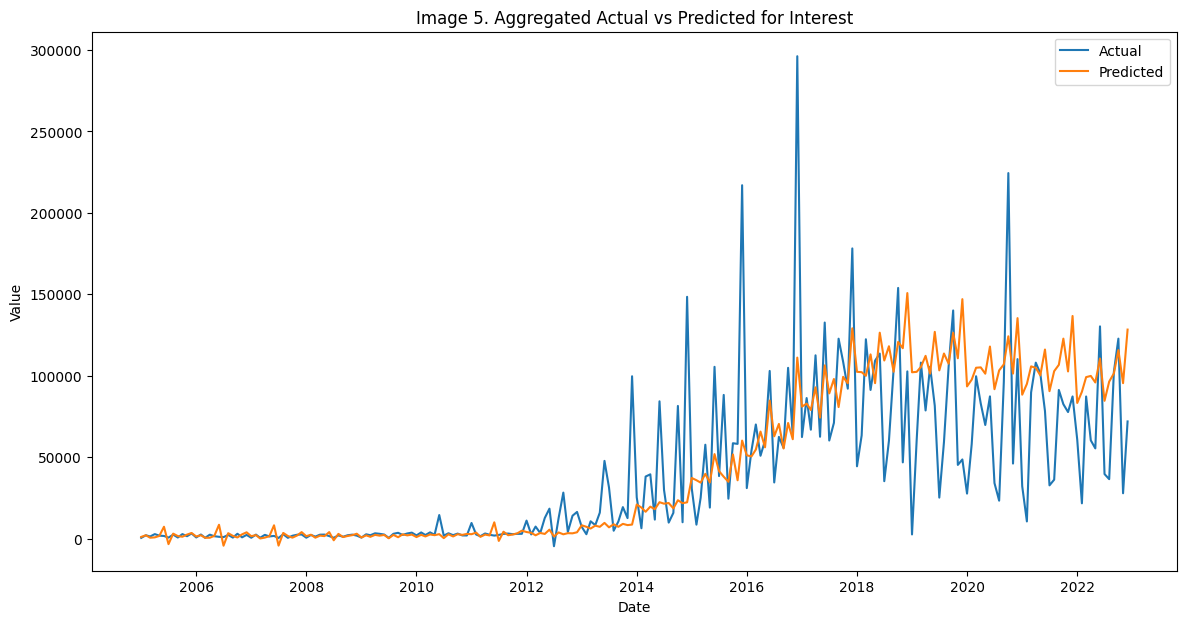

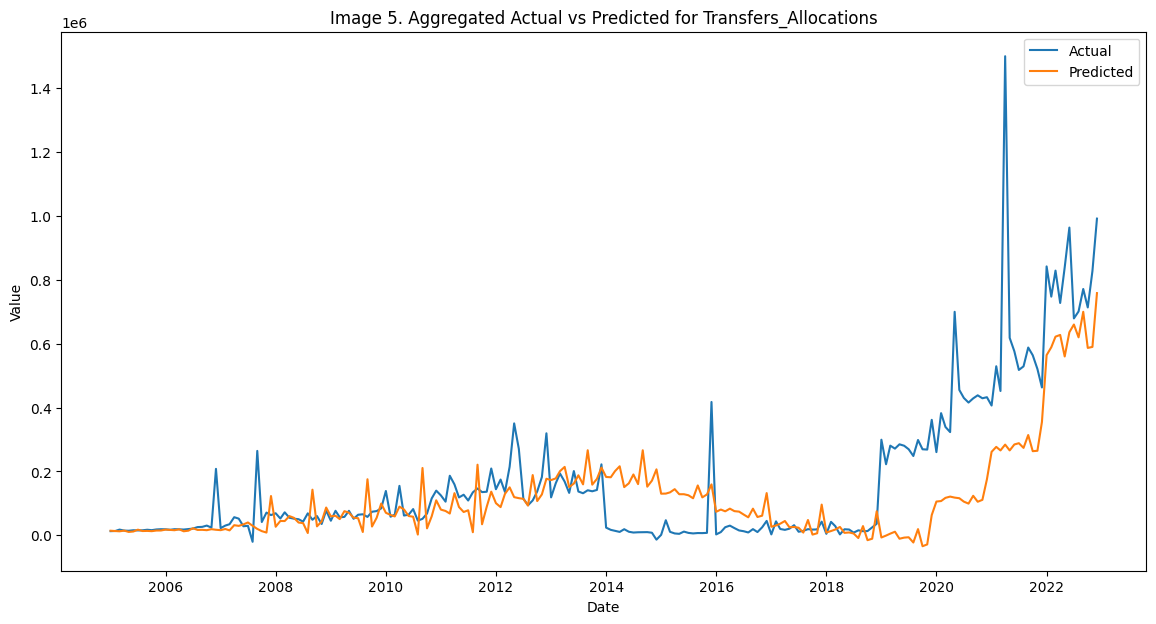

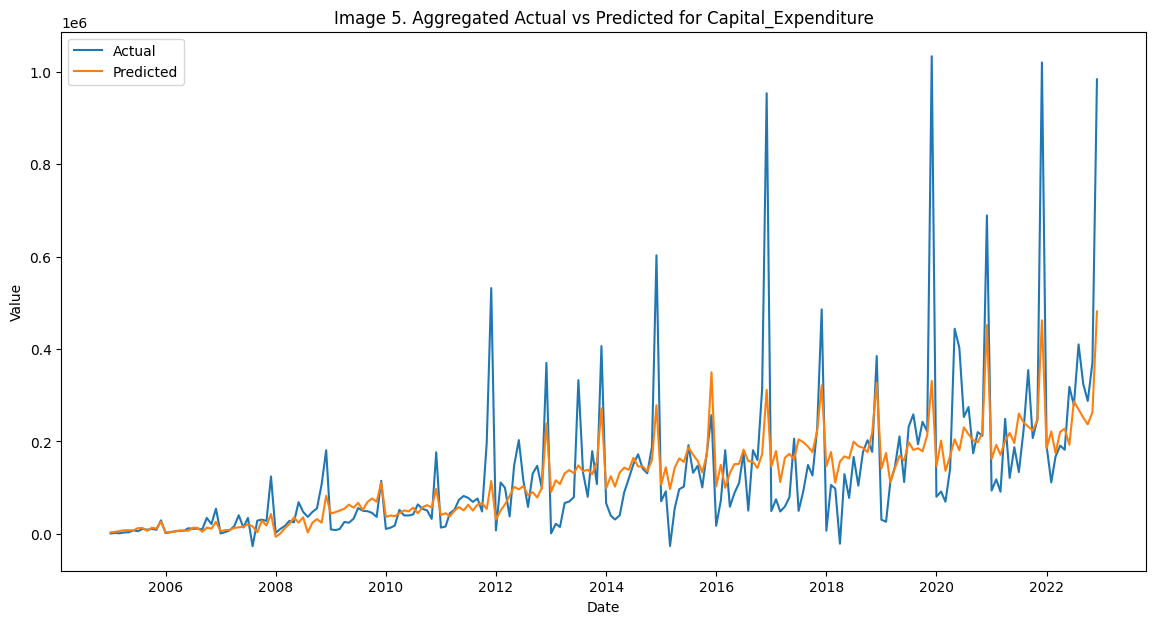

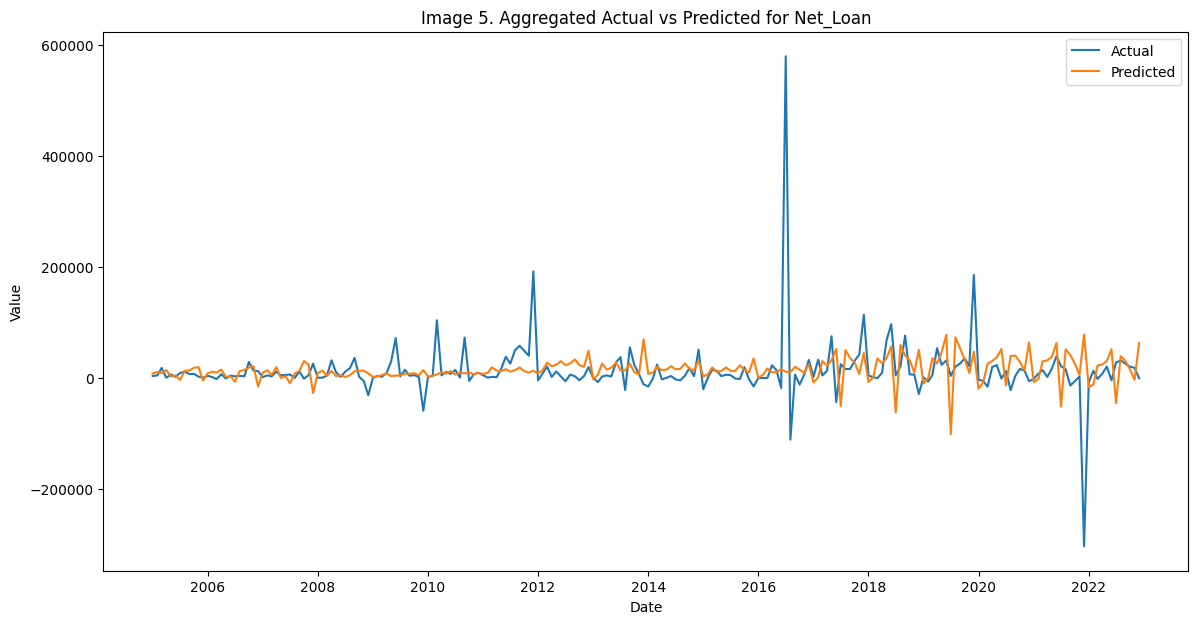

In [13]:
"""
This cell plots the aggregated actual vs predicted values for each column of the Prophet algorithm above.
"""
for column, df in aggregated_predictions.items():
    plt.figure(figsize=(14, 7))
    plt.plot(df['ds'], df['y'], label='Actual')
    plt.plot(df['ds'], df['predicted'], label='Predicted')
    plt.title(f"Image 5. Aggregated Actual vs Predicted for {column}")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

Overall, the performances of these models are good because the results support each other, and they seem to match the general patterns of the actual data, but Prophet failed to predict the high variations in the dataset in the past 10 years. However, this difference can also be an insight into malicious activities since the first 10 years of data were consistent, and suddenly, there are big variations in expenses. 

We have noticed that the expense values in columns Capital_expenditure, Transfers_allocations, Interest, and Goods_Services have more anomalies and inconsistencies throughout the years, which could also give clues on which excuses the politicians use to take more to themselves. We also discussed how even the low-expense categories like Interest have many inconsistencies that need further investigation (e.g., is there any relationship with other columns that cause this?).



## <a id='lstm-autoencoders'></a>LSTM-AutoEncoders 

So far, we have the following insights:

- We used PCA to identify the most insightful categories containing most of the dataset's variance.
- After implementing IsoForest and Prophet algorithms, we can observe that PCA-highlighted categories have been the most insightful categories in the visualization, which shows the efficiency of PCAs.
- We have some clues about how much money the politicians could have stolen throughout the years using MAE.
- We have some clues about which expense categories tend to be used by politicians to steal money.

The algorithms above did a moderate job of finding the anomalies and making a prediction of the dataset. 
Potential improvements for the above-implemented models are:
- Incorporating additional data sources could improve the analysis.
- Implementing advanced anomaly detection techniques and machine learning models for deeper insights.
- Fine-tuning model parameters for better prediction results.

In this last section, we will implement these Potential improvements with LSTM-AutoEncoders. 

First, we must decide whether to train LSTM-AutoEncoders for each column separately or on the whole set combined. To decide, let's look at the correlation between the columns in the below cell. 

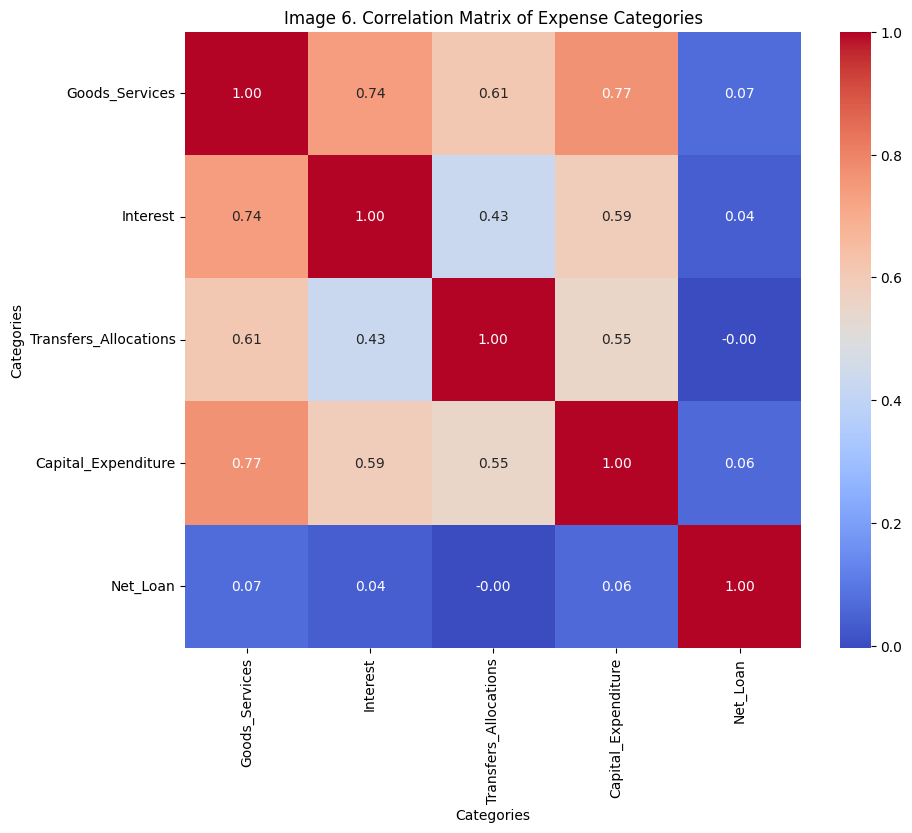

In [14]:
"""
Correlation between the columns
"""
correlation_matrix = df_transposed.corr()

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("Image 6. Correlation Matrix of Expense Categories")
plt.show()


Above, we can see that "Goods_Services" is highly positively correlated with "Interest" (0.74) and "Capital_Expenditure" (0.77), indicating that as spending in "Goods_Services" increases, spending in these categories tends to increase as well.
It has a moderate positive correlation with "Transfers_Allocations" (0.61), suggesting a relationship but less strong than with "Interest" or "Capital_Expenditure."
In general, net_loan has the least correlation with other expense categories, while other columns have some moderate correlation with each other. It would make sense to consider a combined LSTM-autoencoder model only for "Goods_Services," "Interest," "Capital_Expenditure," and "Transfers_Allocations" due to their high inter-correlations. 

We want to build a model with the most optimal parameters, which is what we will do in the cell below with Keras Tuner. Tuner will try different combinations of hyperparameters, including the number of LSTM units in each layer, learning rates, and L2 regularization values, to find the best configuration for our LSTM autoencoder. This process involves training multiple models with varying hyperparameters and evaluating their performance to identify the set that yields the most accurate reconstructions with minimum loss.

In [18]:
"""
This code cell performs hyperparameter optimization for an LSTM autoencoder model. It learns to reconstruct 
the input time series data and any significant deviation in reconstruction can be flagged as an anomaly.
"""

# Import libraries
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, RepeatVector
from keras.models import Model
from keras.regularizers import l2
from keras_tuner.tuners import Hyperband
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.optimizers.legacy import Adam



# Function to build LSTM autoencoder model with tunable hyperparameters
def build_lstm_autoencoder(hp):
    """
    A function that defines the architecture of the LSTM autoencoder. It takes hyperparameters as arguments 
     and returns a compiled model. The hyperparameters include the number of units in the LSTM layers, the 
     learning rate, and the L2 regularization factor.
     
    Parameters:
    hp (HyperParameters): Hyperparameter object for defining the search space.

    Returns:
    keras.Model: A compiled LSTM autoencoder model with specified architecture and hyperparameters.
    """
    # tune parameters: number of units in LSTM layers, learning rate, and L2 regularization
    lstm_units_1 = hp.Int('lstm_units_1', min_value=8, max_value=128, step=8)
    lstm_units_2 = hp.Int('lstm_units_2', min_value=8, max_value=128, step=8)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    l2_reg = hp.Float('l2_reg', min_value=1e-6, max_value=1e-2, sampling='log')

    # Model architecture
    input_layer = Input(shape=(X.shape[1], X.shape[2]))
    
    # Encoder part: LSTM layers to encode the input sequence
    encoder = LSTM(lstm_units_1, activation='relu', return_sequences=True, kernel_regularizer=l2(l2_reg))(input_layer)
    encoder = LSTM(lstm_units_2, activation='relu', return_sequences=False)(encoder)
    
    # Decoder part: LSTM layers to decode the encoded sequence back to original sequence
    decoder = RepeatVector(X.shape[1])(encoder)
    decoder = LSTM(lstm_units_2, activation='relu', return_sequences=True)(decoder)
    decoder = LSTM(lstm_units_1, activation='relu', return_sequences=True)(decoder)
    
    # Output layer to reconstruct the original input
    output_layer = Dense(X.shape[2])(decoder)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return model

# Data preprocessing: normalizing the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_transposed[['Goods_Services', 'Interest', 'Transfers_Allocations', 'Capital_Expenditure']])
X = np.reshape(df_scaled, (df_scaled.shape[0], 1, df_scaled.shape[1]))

# Initialize the hyperparameter tuner
tuner = Hyperband(
    build_lstm_autoencoder,
    objective='val_loss',
    max_epochs=50,
    directory='my_dir',
    project_name='lstm_autoencoder'
)

# Callback for early stopping to prevent overfitting
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Perform the hyperparameter search
tuner.search(X, X, epochs=100, batch_size=32, validation_split=0.1, callbacks=[stop_early])

# Retrieve the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(X, X, epochs=100, batch_size=32, validation_split=0.1, shuffle=True)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Print the best hyperparameters
print(f"The hyperparameter search is complete. The optimal number of LSTM units in the first layer is {best_hps.get('lstm_units_1')}.")
print(f"The optimal number of LSTM units in the second layer is {best_hps.get('lstm_units_2')}.")
print(f"The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")
print(f"The optimal L2 regularization is {best_hps.get('l2_reg')}.")


Reloading Tuner from my_dir/lstm_autoencoder/tuner0.json
Epoch 1/100
9/9 [==============================] - 1s 31ms/step - loss: 0.0061 - val_loss: 0.0367
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0396
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0395
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0439
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0446
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0451
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0427
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0423
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0447
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - los

In [16]:
"""
This code cell trains the model with the optimal hyperparameters
"""
from keras.optimizers import Adam

input_layer = Input(shape=(X.shape[1], X.shape[2]))
encoder = LSTM(best_hps.get('lstm_units_1'), activation='relu', return_sequences=True, 
               kernel_regularizer=l2(best_hps.get('l2_reg')))(input_layer)
encoder = LSTM(best_hps.get('lstm_units_2'), activation='relu', return_sequences=False)(encoder)
decoder = RepeatVector(X.shape[1])(encoder)
decoder = LSTM(best_hps.get('lstm_units_2'), activation='relu', return_sequences=True)(decoder)
decoder = LSTM(best_hps.get('lstm_units_1'), activation='relu', return_sequences=True)(decoder)
output_layer = Dense(X.shape[2])(decoder)

# Construct the final model by specifying the input and output layers
final_model = Model(inputs=input_layer, outputs=output_layer)
# Compile the final model with the Adam optimizer and mean squared error as the loss function
final_model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=best_hps.get('learning_rate')), loss='mse')


# Train the final model using the training data (X), with specified number of epochs, 
# batch size, and validation split. The data is shuffled during training for randomness.
history = final_model.fit(X, X, epochs=100, batch_size=32, validation_split=0.1, shuffle=True)

Before we identify the anomalies, let's see how the model is doing in recunstructing the dataset.

9/9 [==============================] - 0s 957us/step


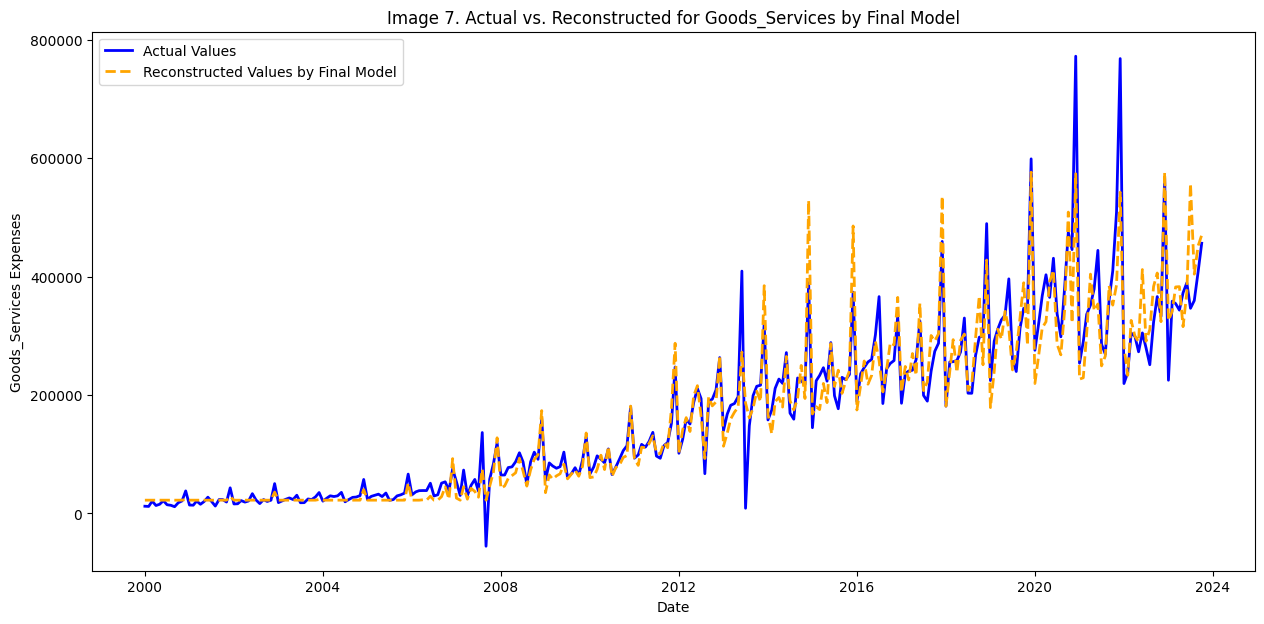

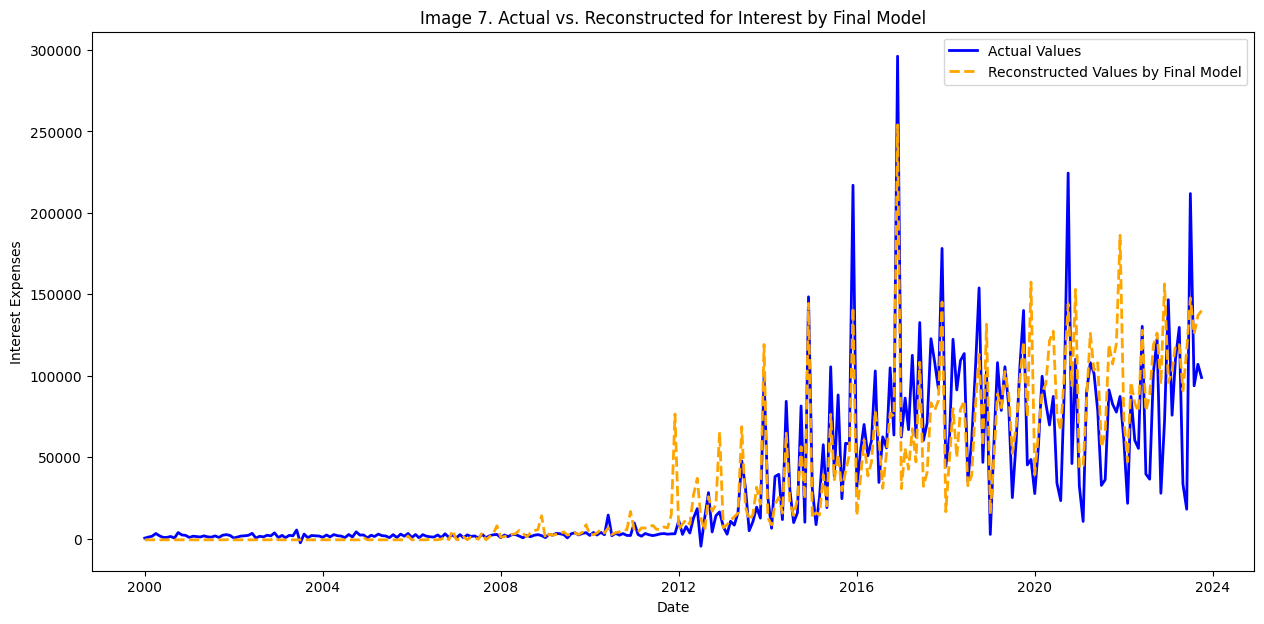

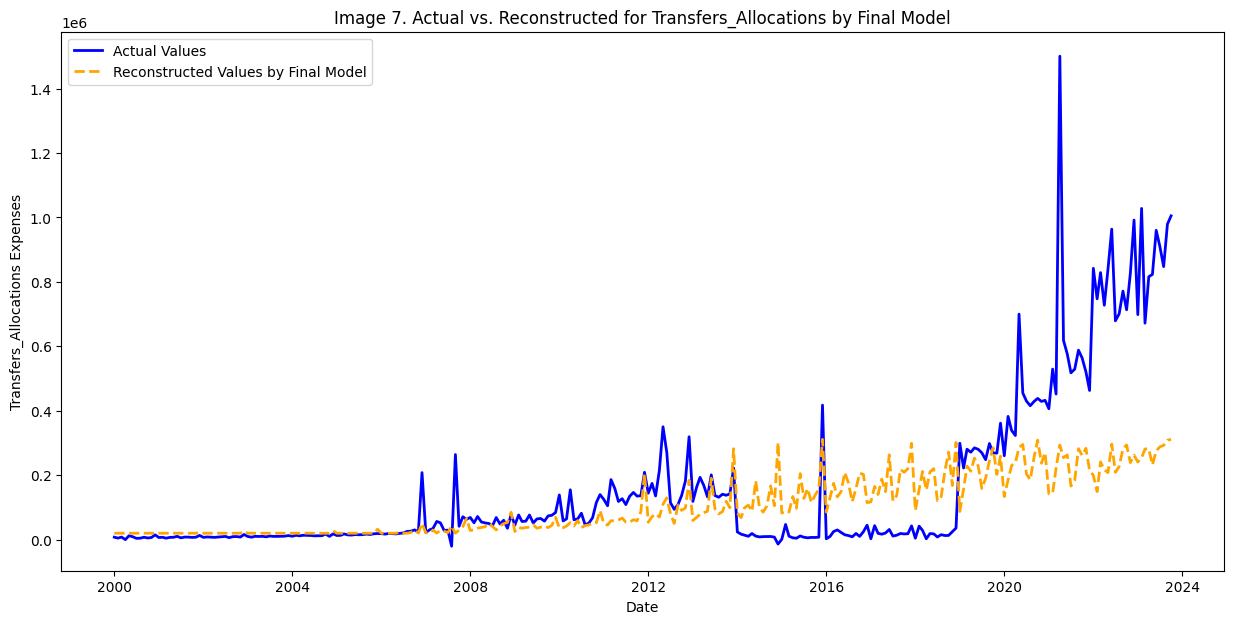

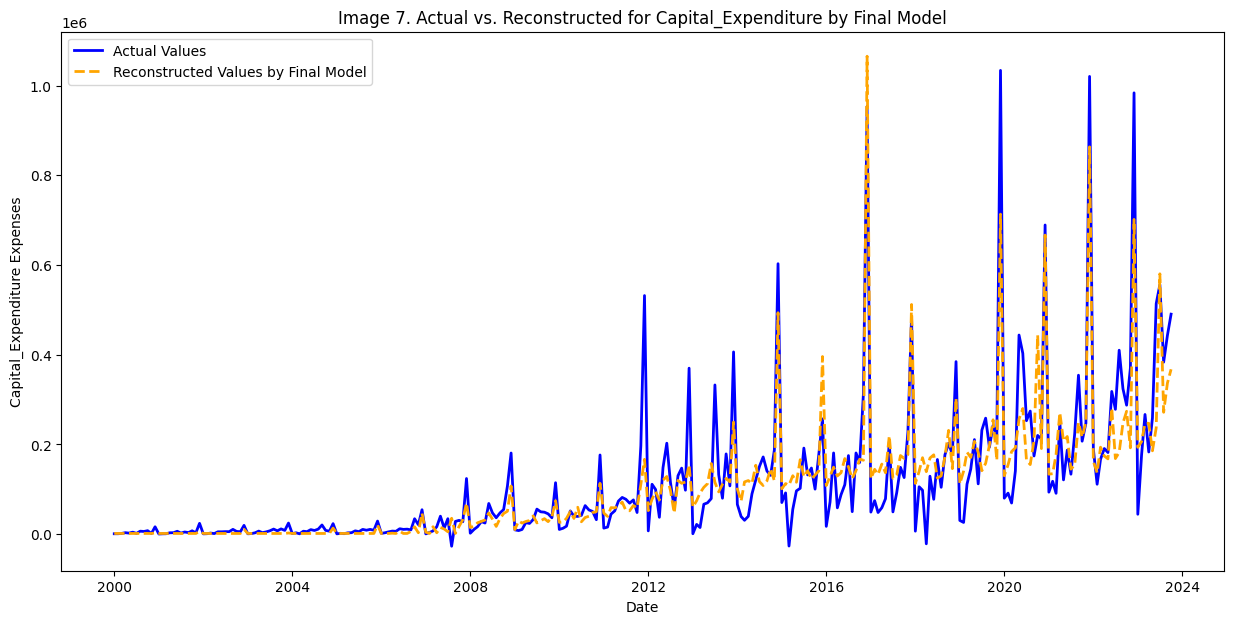

In [20]:
"""
This cell generates a predictions from the final model and compares it with the real data for each column
"""
# Generate predictions from the final model
final_predictions = final_model.predict(X)

# Inverse transform the final model predictions to get them back to the original scale
final_reconstructed_scaled = final_predictions.reshape(final_predictions.shape[0], final_predictions.shape[2])
df_final_reconstructed = scaler.inverse_transform(final_reconstructed_scaled)

# Create a DataFrame for the reconstructed data from the final model
df_final_reconstructed = pd.DataFrame(df_final_reconstructed, columns=['Goods_Services', 'Interest', 'Transfers_Allocations', 'Capital_Expenditure'])
df_final_reconstructed.index = df_transposed.index

# Plotting
COLUMNS = ['Goods_Services', 'Interest', 'Transfers_Allocations', 'Capital_Expenditure']

for i in COLUMNS:
    plt.figure(figsize=(15, 7))
    plt.plot(df_transposed.index, df_transposed[i], label='Actual Values', color='blue', linewidth=2)
    plt.plot(df_final_reconstructed.index, df_final_reconstructed[i], label='Reconstructed Values by Final Model', color='orange', linestyle='--', linewidth=2)
    
    plt.title(f'Image 7. Actual vs. Reconstructed for {i} by Final Model')
    plt.xlabel('Date')
    plt.ylabel(f'{i} Expenses')
    plt.legend()
    plt.show()


The LSTM-autoencoders seem to be doing much better than Prophet since it captures many of the big jumps in the datset of the past few years.
The model performs well on 'Goods_Services', 'Interest', 'Capital_Expenditure' as it captures the general trend and many of the ups and down, 
For Transfers_Allocation, the reconstructed values seem to follow the general trend of the actual values but with less variability. The model captures the overall movement but fails to capture the sharper peaks and troughs in the data. 

Now that we know we have a good model, we will calculate the mean squared errors for the model's reconstruction and set a threshold value. If the reconstruction's error is more than the threshold value, it will be detected as an anomaly. Setting a threshold at the 95% percentile means we're considering the top 5% of data points with the highest reconstruction errors as anomalies. We can change the theshold value whatever we want, but 5% is fine for now since we would expect corrupt activities less often, especially the ones that strategically steal big amount of money. 

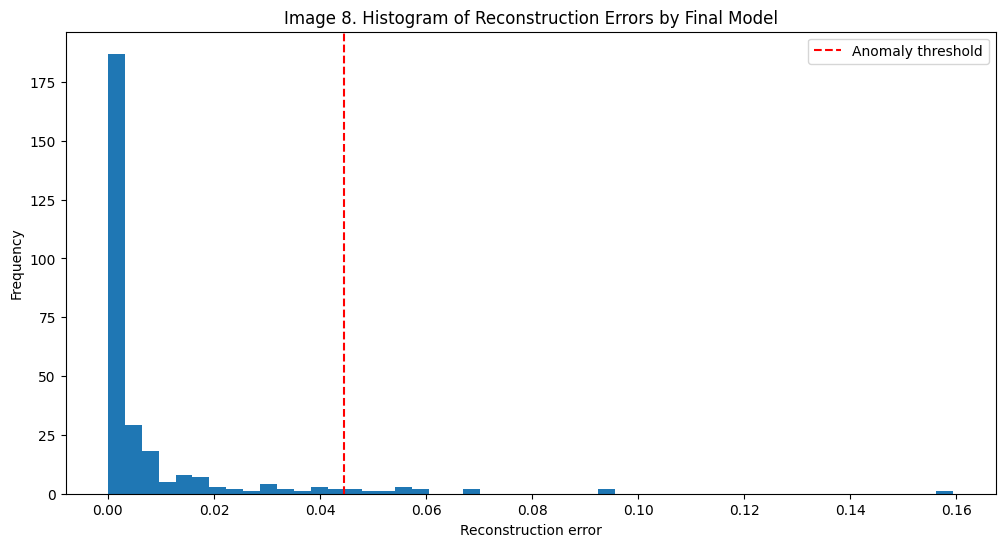

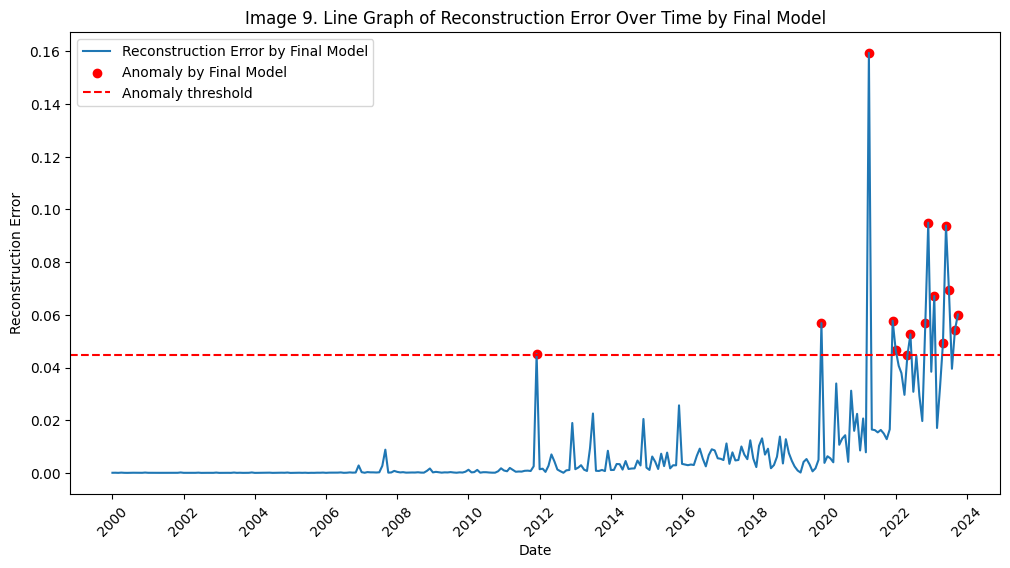

In [21]:
"""
This code cell calculate the mean squared errors and compares each value with the threshold values to identify and plot the anomalies. 
"""

import matplotlib.dates as mdates

# Calculate the mean squared errors for the final model's reconstruction
final_mse = np.mean(np.power(df_scaled - final_predictions.reshape(final_predictions.shape[0], final_predictions.shape[2]), 2), axis=1)
df_final_mse = pd.DataFrame(final_mse, index=df_transposed.index, columns=['mse'])

# Setting the threshold at the 95%
final_threshold = np.quantile(df_final_mse['mse'], 0.95)

# Highlighting the anomalies based on the final model's reconstruction error
df_transposed['final_anomaly'] = df_final_mse['mse'] > final_threshold

# Histogram
plt.figure(figsize=(12, 6))
plt.hist(df_final_mse['mse'], bins=50)
plt.axvline(x=final_threshold, color='r', linestyle='--', label='Anomaly threshold')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.title('Image 8. Histogram of Reconstruction Errors by Final Model')
plt.legend()


# Line Graph 
plt.figure(figsize=(12,6))
plt.plot(df_final_mse.index, df_final_mse['mse'], label='Reconstruction Error by Final Model')
anomalies_final = df_transposed[df_transposed['final_anomaly'] == True]
plt.scatter(anomalies_final.index, df_final_mse.loc[anomalies_final.index, 'mse'], color='red', label='Anomaly by Final Model')
plt.axhline(y=final_threshold, color='r', linestyle='--', label='Anomaly threshold')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Image 9. Line Graph of Reconstruction Error Over Time by Final Model')
plt.legend()
plt.xticks(rotation=45)  
plt.show()


The histogram (Image 8) above shows how many data points are predicted pretty accurately. The ones with even bigger differences, the area right to the threshold line, would be considered anomalies.
Image 9 shows that the reconstruction error isively low and stable until around 2018, suggesting that the data during this period has been reconstructed well by the autoencoder with relatively small errors. Starting around 2018, there was an increase in the reconstruction error with significant spikes. These spikes represent data points the autoencoder model found difficult to reconstruct accurately, marked as anomalies (red dots).
Some anomalies, particularly in later years like 2020 and beyond, have a high reconstruction error. This could suggest more malicious activities or that the model is becoming less effective at predicting new data points. 

Let's look at the dates of these anomalies below.

In [22]:
'''
this cell prints the dates of the red points above the threshold. 
'''
anomaly_dates = df_transposed[df_transposed['final_anomaly'] == True].index

# Printing the anomaly dates
print("Anomaly Dates:")
for i in anomaly_dates.tolist():
    print(i)


Anomaly Dates:
2011-12-01 00:00:00
2019-12-01 00:00:00
2021-04-01 00:00:00
2021-12-01 00:00:00
2022-01-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-02-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00


As a reminder, these anomalies were detected by Isolation Forest before. 

2011-12              
2013-07                
2014-12                
2015-12                
2016-07                
2016-08                
2016-12                
2017-12                
2018-12                
2019-12                
2020-10                
2020-12                
2021-04                
2021-12                
2022-06                
2022-12                
2023-01                
2023-06                
2023-07                
2023-09                
2023-10   

Most of them match with Isolation Forest's prediction, which could be interpreted as likely for these points to be real anomalies. The dates that do not match are probably because of the threshold value we set in the LSTM-Autoencoders. If we lower them, we will likely get more points that will match, but the current threshold is also good. Now that we are more sure about the anomalous dates let's dig more into the news to make connections about what could have happened. 

We have many anomalies detected in 2023. In 2023, there has been a major scandal related to public buses throughout the year. The image below is related to the news about the supposedly newly made public bus imported from Korea. The government announced that the price of each bus is 400 million tugriks, which is an amount enough to buy 2 of the most modern buses in the world (С.Отгонбаяр, Өдрийн сонин 2023). When professionals inspected the bus, they reported that the bus was not newly made; instead, it is an old Korean bus that has been repainted and repaired, which will not cost 400 million tugriks (С.Отгонбаяр, Өдрийн сонин 2023). And they have bought 160 of them. This project could be one of the main reasons for such high anomalous expenditure in 2023.
<img src="attachment:acdfdff7-4fbb-4174-98c3-d838fd1c4ee0.png" width="700" />

There is also much news related to expenditures for Covid between 2020-2022, where they budgeted 20 trillion tugriks for COVID-related projects. The news reported that the actual expenditures of the implemented projects only add up to a few billion tugriks, including buying vaccines, freeing citizens from electricity bills, and investing in hospitals. Coincidentally, 4-5 officials who were responsible for covid related budgets have bought houses worth billions of tugriks("О.Цогтгэрэл: Ковидын төсвийг хариуцаж байсан 4-5 албан тушаалтан тэрбумын үнэтэй байр худалдаж авсан" 2023). This news could explain the strange expenditures during 2020-2022.

Over the years, there has been another big and mysterious scandal about missing a big amount of money from selling coal to international countries. Some officials report that these malicious activities could have been executed in 2017 when coal prices increased (https://www.facebook.com/niitlelchid 2023). The clue is that the price of coal has been rising, and Mongolia has been constantly mining and selling coal to other countries yearly, but the profit and the spending they have reported need to add up to calculations. Therefore, there could be some correlation between this case and the rise of anomalies in the last 5 years. 

There was a high spike in December of 2019. I tried looking for resources on the news about what they did in December 2019. I could only find the report on their budget expenditure for the 1st quarter of the year, where they report that they have been spending less money than budgeted ("Монгол улсын нэгдсэн төсвийн 2019 оны нэгдүгээр улирлын гүйцэтгэлийн мэдээ - САНГИЙН ЯАМ" 2019) The high spike at the end of the year should be investigated more to identify whether the anomalous expenditure at the end of the year was related to corrupt activities or not. 


## <a id='summary'></a>Summary 

To sum up, we identified a problem and goal, selected a dataset, preprocessed it, explained the workings of relevant models, did PCA, executed anomaly detection and time series prediction models, identified improvements, implemented the improvements with LSTM-Autoencoders, compared results, interpreted the anomalies with real news related to these dates. We used different anomaly detection techniques to compare and understand why such anomalies could occur over the years. The significant expenditure increase in the past few years is the reason why these scandals started since the expense was rising while the economy and the state of the people's lives got worse. 

In general, the models' outputs aligned with each other well, which helped us critically assess each model's performance and interpretation of the results. It is important to note that I do not assume any model is perfect and falsely convict people for corruption or thievery. This project's main goal is to statistically analyze the publicly available data and identify the points that are anomalous and connect the findings with real-life news available on the internet. (Note: some of the sources are from Facebook because it is a common platform for Mongolians to share social issues.)

One of the interesting findings is that there are many anomalies detected in December in different years. This can be due to the fact that many project have to finish their work and they might lose their funding for the next years. 

For further improvement, we need labeled data of actual corruption cases and feed it to models for better prediction. 



### AI Policy Statement
I used AI tools to assist with understanding the models, coding, and summarizing readings. Plus, AI was used to grammar check my writings. 

## <a id='references'></a>References

Khare, Pratyush. “Understanding FB Prophet: A Time Series Forecasting Algorithm.” Medium, ILLUMINATION, 13 May 2023, medium.com/illumination/understanding-fb-prophet-a-time-series-forecasting-algorithm-c998bc52ca10. Accessed 2 Dec. 2023.

‌Shrivastava, Soumya. “Cross Validation in Time Series - Soumya Shrivastava - Medium.” Medium, Medium, 14 Jan. 2020, medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4. Accessed 2 Dec. 2023.

“Статистикийн мэдээллийн нэгдсэн сан.” 2023. 1212.Mn. 2023. https://www.1212.mn/mn/statistic/statcate/573058/table-view/DT_NSO_0800_005V1.

С.Отгонбаяр, Өдрийн сонин. 2023. “А.Дугардорж: ‘Ногоон’ шиг капитал автобус босгоход хамгийн үнэтэй нь 25 мянган Ам.доллар болно.” Ikon.mn. October 13, 2023. https://ikon.mn/n/2zcl.

‌“Монгол улсын нэгдсэн төсвийн 2019 оны нэгдүгээр улирлын гүйцэтгэлийн мэдээ - САНГИЙН ЯАМ.” 2019. Монгол Улсын Сангийн яам. 2019. https://mof.gov.mn/article/entry/ulirliin-medee-irgediin-tusuv?fbclid=IwAR051EpjbEIs08s6LjOX_uF_wiMCmSSBTf9T8ad1itff47ECK2Q6HeT8KOs.

https://www.facebook.com/niitlelchid. 2023. “‘НҮҮРСНИЙ ХУЛГАЙ’ гэх дуулианы ард - Niitlel.mn.” Niitlel.mn. March 31, 2023. https://niitlel.mn/%D0%BD%D2%AF%D2%AF%D1%80%D1%81%D0%BD%D0%B8%D0%B9-%D1%85%D1%83%D0%BB%D0%B3%D0%B0%D0%B9-%D0%B3%D1%8D%D1%85-%D0%B4%D1%83%D1%83%D0%BB%D0%B8%D0%B0%D0%BD%D1%8B-%D0%B0%D1%80%D0%B4/
‌
‌“О.Цогтгэрэл: Ковидын төсвийг хариуцаж байсан 4-5 албан тушаалтан тэрбумын үнэтэй байр худалдаж авсан.” 2023. Www.shuud.mn. www.shuud.mn. October 23, 2023. http://www.shuud.mn/a/553408.

Pooyan Mobtahej, et al. “An LSTM-Autoencoder Architecture for Anomaly Detection Applied on Compressors Audio Data.” Computational and Mathematical Methods, vol. 2022, 29 Sept. 2022, pp. 1–22, www.hindawi.com/journals/cmm/2022/3622426/, https://doi.org/10.1155/2022/3622426. Accessed 16 Dec. 2023.

Qais, Mohammed H., et al. “LSTM-Based Stacked Autoencoders for Early Anomaly Detection in Induction Heating Systems.” Mathematics, vol. 11, no. 15, 28 July 2023, p. 3319, kau.diva-portal.org/smash/get/diva2:1791086/FULLTEXT01.pdf, https://doi.org/10.3390/math11153319. Accessed 16 Dec. 2023.
‌‌